# AI Decision Intelligence & Governance Platform  
## Step 1: Credit Risk Dataset Overview

This notebook explores the UCI Credit Card Default dataset to understand
its structure, features, and business meaning before modeling.

In [94]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

In [95]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [96]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
ARTIFACT_DIR = os.path.join(PROJECT_ROOT, "reports", "artifacts")

os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [97]:
file_path = "../data/raw/default of credit card clients.xls"

df = pd.read_excel(file_path, header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Step 2: Decision Intelligence Framing

### Business Context
Banks issue credit cards with a fixed credit limit. Some customers default on their payments, causing financial loss.

### Decision to be Made
Should the bank:
- Approve a credit limit?
- Increase / decrease an existing limit?
- Flag a customer as high risk?

This system predicts the probability of default to support these decisions.

### Target Variable Definition

The dataset contains a column:
- `default.payment.next.month`

Meaning:
- 1 → Customer will default
- 0 → Customer will not default

This is NOT just a label — it represents financial risk exposure.

### Cost of Decision Errors

False Positive (predict default but customer is safe):
- Lost revenue
- Reduced customer trust

False Negative (predict safe but customer defaults):
- Direct financial loss
- Increased credit risk exposure

Business priority:
❗ False Negatives are more expensive than False Positives

## Step 3: Feature Understanding & Intelligence

### Core Feature Groups

This dataset contains four major feature categories:

1. Demographic Information
2. Credit Limit Information
3. Repayment History
4. Billing & Payment Behavior

### 1. Demographic Features

| Feature | Meaning | Decision-Time Availability |
|-------|--------|----------------------------|
| SEX | Gender of customer | Yes |
| EDUCATION | Education level | Yes |
| MARRIAGE | Marital status | Yes |
| AGE | Age in years | Yes |

These features describe who the customer is, not how they behave financially.

### 2. Credit Exposure Feature

| Feature | Meaning |
|-------|--------|
| LIMIT_BAL | Total credit limit assigned to the customer |

This represents the maximum financial exposure the bank has for a customer.
Higher limits = higher potential loss.

### 3. Repayment History Features

| Feature | Meaning |
|-------|--------|
| PAY_0 | Repayment status last month |
| PAY_2 to PAY_6 | Repayment status for previous months |

Values:
- -1 → Paid on time
- 0 → Paid with delay
- 1+ → Months of delay

These features capture customer discipline and financial stress.

### 4. Billing & Payment Behavior

| Feature | Meaning |
|-------|--------|
| BILL_AMT1 to BILL_AMT6 | Monthly bill amounts |
| PAY_AMT1 to PAY_AMT6 | Actual payments made |

These features show:
- Spending behavior
- Repayment capacity
- Consistency of payments

### Feature Risk Classification

| Feature Type | Risk |
|-------------|------|
| Demographics | Low |
| Credit Limit | Medium |
| Repayment History | High |
| Billing & Payments | Very High |

Incorrect interpretation of high-risk features can lead to:
- Data leakage
- Unrealistic production performance

## Step 4: Exploratory Risk Analysis

### Target Variable

The target variable is:
- `default.payment.next.month`

Where:
- 1 → Customer defaulted
- 0 → Customer did not default

In [98]:
df.shape

(30000, 25)

In [99]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month'],
      dtype='object')

In [100]:
df['default payment next month'].value_counts(normalize=True)

default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

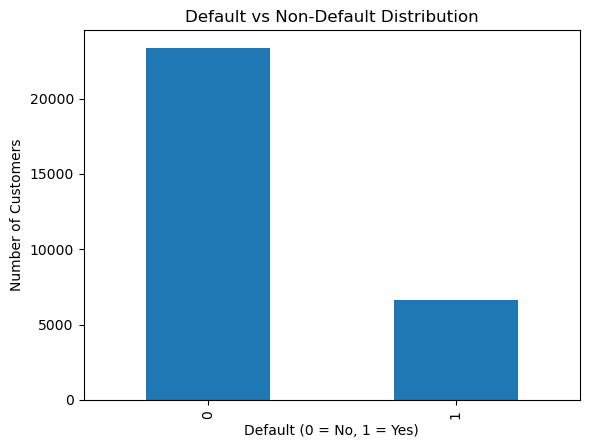

In [101]:
import matplotlib.pyplot as plt

df['default payment next month'].value_counts().plot(
    kind='bar',
    title='Default vs Non-Default Distribution'
)

plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()

In [102]:
df.groupby('default payment next month')['AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
default payment next month,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0


In [103]:
df.groupby('default payment next month')['LIMIT_BAL'].mean()

default payment next month
0    178099.726074
1    130109.656420
Name: LIMIT_BAL, dtype: float64

In [104]:
repayment_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

df.groupby('default payment next month')[repayment_cols].mean()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
default payment next month,,,,,,
0,-0.211222,-0.301917,-0.316256,-0.355633,-0.389488,-0.405624
1,0.668174,0.458258,0.362116,0.254521,0.167872,0.112116


### Note on Column Naming

This dataset originates from academic research and uses space-separated
column names. Care must be taken when referencing columns programmatically.

## Step 5: Feature Engineering for Risk Intelligence

Objective:
Transform raw repayment and billing variables into higher-level behavioral
signals that reflect customer credit risk patterns over time.

In [105]:
repayment_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

df['avg_repayment_delay'] = df[repayment_cols].mean(axis=1)
df['max_repayment_delay'] = df[repayment_cols].max(axis=1)

In [106]:
df[['avg_repayment_delay', 'max_repayment_delay']].describe()

,avg_repayment_delay,max_repayment_delay
count,30000.000000,30000.000000
mean,-0.182439,0.438733
std,0.982176,1.345154
min,-2.000000,-2.000000
25%,-0.833333,0.000000
50%,0.000000,0.000000
75%,0.000000,2.000000
max,6.000000,8.000000


In [107]:
bill_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

df['avg_bill_amount'] = df[bill_cols].mean(axis=1)
df['credit_utilization_ratio'] = df['avg_bill_amount'] / df['LIMIT_BAL']

In [108]:
df['credit_utilization_ratio'].describe()

count    30000.000000
mean         0.373048
std          0.351890
min         -0.232590
25%          0.029997
50%          0.284834
75%          0.687929
max          5.364308
Name: credit_utilization_ratio, dtype: float64

In [109]:
df['repayment_volatility'] = df[repayment_cols].std(axis=1)

In [110]:
df['behavioral_risk_score'] = (
    0.5 * df['avg_repayment_delay'] +
    0.3 * df['credit_utilization_ratio'] +
    0.2 * df['repayment_volatility']
)

### Behavioral Risk Score

A composite score designed to summarize repayment behavior,
credit exposure, and payment stability into a single interpretable metric.
This mirrors enterprise credit risk scoring approaches used in decision systems.

In [111]:
df.groupby('default payment next month')['behavioral_risk_score'].mean()

default payment next month
0    0.017575
1    0.442464
Name: behavioral_risk_score, dtype: float64

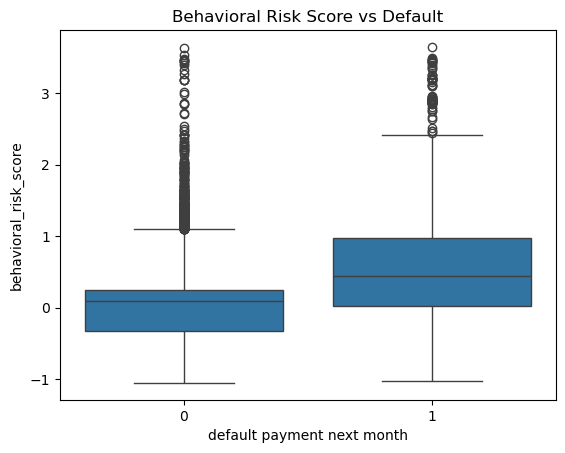

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default payment next month',
    y='behavioral_risk_score',
    data=df
)

plt.title('Behavioral Risk Score vs Default')
plt.show()

## Step 6: Modeling Architecture (Baseline + Challenger)

Objective:
Build a governance-ready risk model pipeline with reproducible preprocessing,
baseline + challenger models, and evaluation metrics aligned to decision systems.

In [113]:
target_col = 'default payment next month'

X = df.drop(columns=[target_col])
y = df[target_col]

In [114]:
X.shape, y.shape, y.value_counts(normalize=True)

((30000, 30),
 (30000,),
 default payment next month
 0    0.7788
 1    0.2212
 Name: proportion, dtype: float64)

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [116]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(default payment next month
 0    0.778792
 1    0.221208
 Name: proportion, dtype: float64,
 default payment next month
 0    0.778833
 1    0.221167
 Name: proportion, dtype: float64)

In [117]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [118]:
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000))
])

In [119]:
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ID', 'LIMIT_BAL', 'AGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'avg_repayment_delay',
                                                   'max_repayment_delay',
                                                   'avg_bill_amount',
                                                   'credit_utilization_ratio',
                                                   'repayment_volatility',
                                                   'behavioral_risk_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE'])])),
                ('model', LogisticRegression(max_iter=2000))])

In [120]:
from sklearn.ensemble import HistGradientBoostingClassifier

challenger_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', HistGradientBoostingClassifier(random_state=42))
])

challenger_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ID', 'LIMIT_BAL', 'AGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'avg_repayment_delay',
                                                   'max_repayment_delay',
                                                   'avg_bill_amount',
                                                   'credit_utilization_ratio',
                                                   'repayment_volatility',
                                                   'behavioral_risk_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE'])])),
                ('model', HistGradientBoostingClassifier(random_state=42))])

In [121]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)

def evaluate_model(name, model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)

    print(f"\n===== {name} =====")
    print("ROC-AUC:", roc_auc_score(y_test, probs))
    print("PR-AUC:", average_precision_score(y_test, probs))
    print("\nClassification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

evaluate_model("Baseline (LogReg)", baseline_model, X_test, y_test)
evaluate_model("Challenger (HistGB)", challenger_model, X_test, y_test)


===== Baseline (LogReg) =====
ROC-AUC: 0.7273335525427785
PR-AUC: 0.49595431525653877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.88      4673
           1       0.66      0.23      0.34      1327

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.76      6000

Confusion Matrix:
 [[4517  156]
 [1024  303]]

===== Challenger (HistGB) =====
ROC-AUC: 0.780192082948252
PR-AUC: 0.5573268097363834

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.66      0.37      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:
 [[4415  258]
 [ 832  495]]


## Step 7: Decision Threshold Optimization

In credit risk, false negatives (missed defaulters) are significantly more costly than false positives.
This section evaluates model performance across decision thresholds to identify an optimal business-aligned cutoff.

In [122]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve

probs = challenger_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs)

threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

threshold_df.head()

,threshold,precision,recall
0,0.013862,0.221167,1.0
1,0.014616,0.221204,1.0
2,0.014711,0.221240,1.0
3,0.018697,0.221277,1.0
4,0.019689,0.221314,1.0


## Step 7.2: Cost-Sensitive Risk Optimization

Instead of optimizing for accuracy or AUC, we simulate business costs where
missing a defaulter (False Negative) is significantly more expensive than
incorrectly rejecting a good customer (False Positive).

In [123]:
from sklearn.metrics import confusion_matrix

FN_COST = 10
FP_COST = 1

costs = []

for t in threshold_df["threshold"]:
    preds = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    total_cost = (fn * FN_COST) + (fp * FP_COST)
    
    costs.append(total_cost)

threshold_df["business_cost"] = costs
threshold_df.sort_values("business_cost").head()

,threshold,precision,recall,business_cost
1146,0.072597,0.261389,0.955539,4173
1036,0.068694,0.257609,0.963075,4173
1145,0.072542,0.261336,0.955539,4174
1035,0.068686,0.257557,0.963075,4174
1144,0.072466,0.261282,0.955539,4175


In [124]:
optimal_row = threshold_df.loc[threshold_df["business_cost"].idxmin()]
optimal_threshold = optimal_row["threshold"]

optimal_threshold

0.06869436685665209

## Step 8: Risk Tiering & Decision Policy

Instead of a binary classification, predictions are converted into
risk tiers that align with real-world credit decision workflows.

In [125]:
def assign_risk_tier(prob):
    if prob < optimal_threshold * 0.7:
        return "Low Risk"
    elif prob < optimal_threshold:
        return "Medium Risk"
    else:
        return "High Risk"

decision_df = X_test.copy()
decision_df["default_probability"] = probs
decision_df["risk_tier"] = decision_df["default_probability"].apply(assign_risk_tier)

decision_df["decision"] = decision_df["risk_tier"].map({
    "Low Risk": "Auto-Approve",
    "Medium Risk": "Manual Review",
    "High Risk": "Reject"
})

decision_df[["default_probability", "risk_tier", "decision"]].head(10)

,default_probability,risk_tier,decision
6907,0.139285,High Risk,Reject
24575,0.135743,High Risk,Reject
26766,0.157202,High Risk,Reject
2156,0.180497,High Risk,Reject
3179,0.039207,Low Risk,Auto-Approve
29382,0.387322,High Risk,Reject
24454,0.226143,High Risk,Reject
23886,0.025554,Low Risk,Auto-Approve
5504,0.093264,High Risk,Reject
29720,0.096927,High Risk,Reject


In [126]:
decision_df["decision"].value_counts(normalize=True)

decision
Reject           0.826833
Auto-Approve     0.088333
Manual Review    0.084833
Name: proportion, dtype: float64

## Step 9: Explainability (SHAP) + Reason Codes

This step explains *why* the model made each decision by identifying
the top contributing features per prediction. This is required for:
- trust (stakeholders understand decisions)
- governance (auditability)
- compliance (decision reason codes)

In [127]:
import shap
import numpy as np

# -----------------------------
# SHAP for Challenger Model (tree-based) + Pipeline preprocessing
# -----------------------------
# Challenger pipeline objects
preprocessor = challenger_model.named_steps["preprocess"]
model = challenger_model.named_steps["model"]

# Transform the SAME rows you are making decisions on (X_test -> decision_df)
X_explain = X_test.copy()
X_transformed = preprocessor.transform(X_explain)
feature_names = preprocessor.get_feature_names_out()

# Tree-based SHAP explainer (fast + stable)
explainer = shap.Explainer(
    model,
    X_transformed,
    feature_names=feature_names
)

# SHAP values for ALL test rows (should align 1-to-1 with decision_df)
shap_values = explainer(
    X_transformed,
    check_additivity=False
)

shap_values.values.shape


(6000, 40)

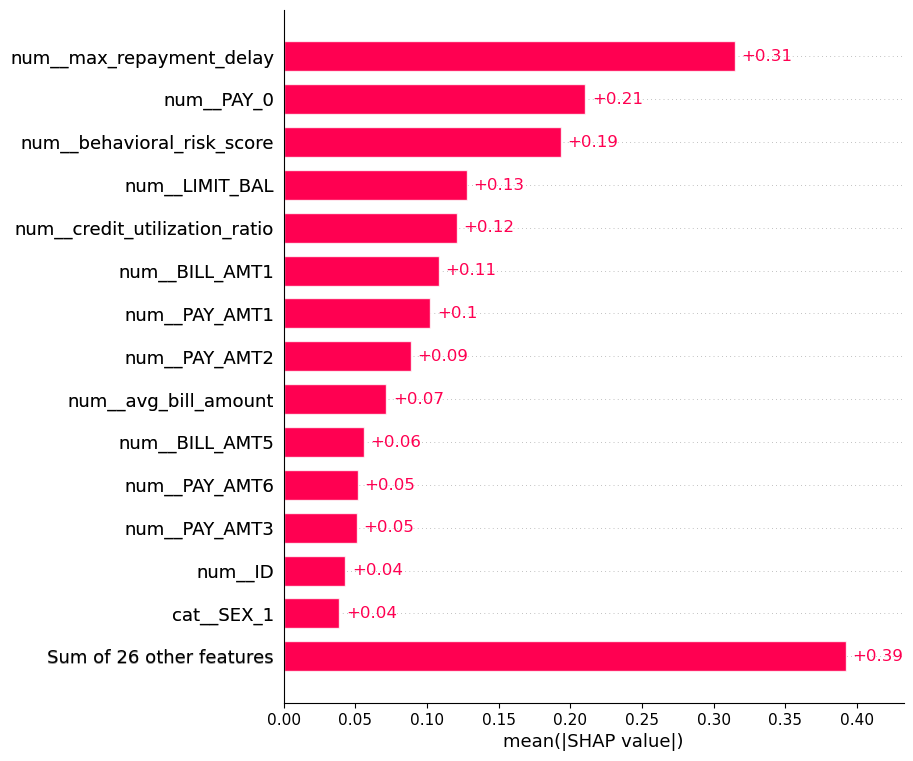

In [128]:
# Global feature importance (mean |SHAP|) for the Challenger model
shap.plots.bar(shap_values, max_display=15)


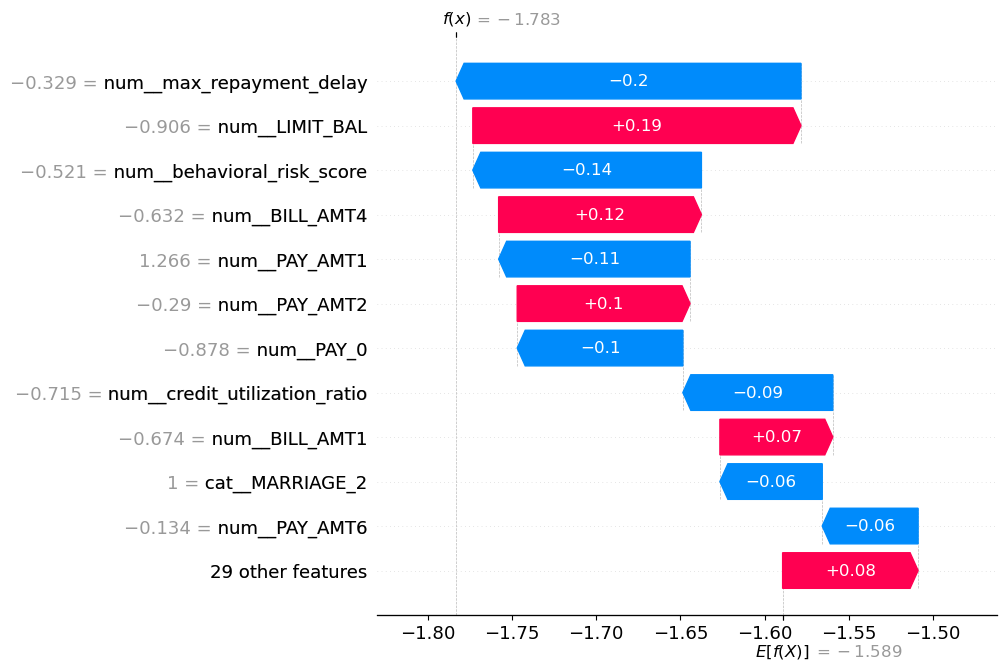

In [129]:
# Example-level explanation (waterfall)
example_idx = 0
shap.plots.waterfall(shap_values[example_idx], max_display=12)


In [130]:
# -----------------------------
# Reason Codes (top 3 drivers per row)
# -----------------------------
# Compute top 3 reasons for every decision row (same order as decision_df)
shap_matrix = shap_values.values  # shape: (n_rows, n_features)
top_idx = np.argsort(np.abs(shap_matrix), axis=1)[:, -3:][:, ::-1]

reason_1 = [feature_names[i[0]] for i in top_idx]
reason_2 = [feature_names[i[1]] for i in top_idx]
reason_3 = [feature_names[i[2]] for i in top_idx]

# Attach to decision_df (DO NOT recreate decision_df)
decision_df["reason_1"] = reason_1
decision_df["reason_2"] = reason_2
decision_df["reason_3"] = reason_3

decision_df[["default_probability", "risk_tier", "decision", "reason_1", "reason_2", "reason_3"]].head()


,default_probability,risk_tier,decision,reason_1,reason_2,reason_3
6907,0.139285,High Risk,Reject,num__max_repayment_delay,num__LIMIT_BAL,num__behavioral_risk_score
24575,0.135743,High Risk,Reject,num__max_repayment_delay,num__PAY_AMT1,num__BILL_AMT1
26766,0.157202,High Risk,Reject,num__credit_utilization_ratio,num__max_repayment_delay,num__LIMIT_BAL
2156,0.180497,High Risk,Reject,num__credit_utilization_ratio,num__BILL_AMT1,num__PAY_AMT3
3179,0.039207,Low Risk,Auto-Approve,num__behavioral_risk_score,num__max_repayment_delay,num__LIMIT_BAL


In [131]:
# --- Helper function: approval rate by protected group ---
def approval_rate_by_group(df, group_col):
    return (
        df.groupby(group_col)["approved_flag"]
          .mean()
          .reset_index(name="approval_rate")
    )

In [132]:
# --- Helper function: Disparate Impact (80% rule) ---
def disparate_impact(df, group_col):
    rates = (
        df.groupby(group_col)["approved_flag"]
          .mean()
    )

    min_rate = rates.min()
    max_rate = rates.max()

    di_ratio = min_rate / max_rate if max_rate > 0 else 0
    return di_ratio

## Step 10.1: Fairness & Bias Assessment
This step evaluates whether the automated credit decision system
exhibits disparate impact across protected or sensitive attributes.

In [133]:
fairness_df = decision_df.copy()

# Reattach sensitive attributes
fairness_df["SEX"] = X_test["SEX"].values
fairness_df["EDUCATION"] = X_test["EDUCATION"].values
fairness_df["AGE"] = X_test["AGE"].values

fairness_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,avg_repayment_delay,max_repayment_delay,avg_bill_amount,credit_utilization_ratio,repayment_volatility,behavioral_risk_score,default_probability,risk_tier,decision,reason_1,reason_2,reason_3
6907,6908,50000,1,2,2,46,-1,-1,-1,-1,0,0,1540,26060,0,2650,3320,2764,26060,0,3472,2320,1764,2841,-0.666667,0,6055.666667,0.121113,0.516398,-0.193720,0.139285,High Risk,Reject,num__max_repayment_delay,num__LIMIT_BAL,num__behavioral_risk_score
24575,24576,150000,1,1,1,31,-1,-1,-2,-2,-2,-1,15000,0,0,0,0,11694,0,0,0,0,11694,30000,-1.500000,-1,4449.000000,0.029660,0.547723,-0.631557,0.135743,High Risk,Reject,num__max_repayment_delay,num__PAY_AMT1,num__BILL_AMT1
26766,26767,50000,1,2,2,25,0,0,0,0,0,0,48065,48355,49009,49949,50479,50702,1800,1844,2200,2000,1800,2038,0.000000,0,49426.500000,0.988530,0.000000,0.296559,0.157202,High Risk,Reject,num__credit_utilization_ratio,num__max_repayment_delay,num__LIMIT_BAL
2156,2157,290000,2,1,2,25,0,0,0,0,0,0,305823,303701,296384,248801,241983,230925,15000,10500,10000,15000,7844,23333,0.000000,0,271269.500000,0.935412,0.000000,0.280624,0.180497,High Risk,Reject,num__credit_utilization_ratio,num__BILL_AMT1,num__PAY_AMT3
3179,3180,500000,2,2,1,27,-2,-2,-2,-2,-2,-2,11354,9983,13570,10000,10000,10000,9983,13587,10000,10000,10000,25304,-2.000000,-2,10817.833333,0.021636,0.000000,-0.993509,0.039207,Low Risk,Auto-Approve,num__behavioral_risk_score,num__max_repayment_delay,num__LIMIT_BAL


In [134]:
# Create approval flag for fairness analysis
fairness_df["approved_flag"] = fairness_df["decision"].isin(
    ["Auto-Approve", "Manual Review"]
).astype(int)

In [135]:
approval_rate_by_group(fairness_df, "SEX")

,SEX,approval_rate
0,1,0.144463
1,2,0.192329


In [136]:
approval_rate_by_group(fairness_df, "EDUCATION")

,EDUCATION,approval_rate
0,0,0.000000
1,1,0.227230
2,2,0.138068
3,3,0.128205
4,4,0.307692
5,5,0.755556
6,6,0.000000


In [137]:
fairness_df["AGE_GROUP"] = pd.cut(
    fairness_df["AGE"],
    bins=[20, 30, 40, 50, 60, 80],
    labels=["20s", "30s", "40s", "50s", "60+"]
)

approval_rate_by_group(fairness_df, "AGE_GROUP")

,AGE_GROUP,approval_rate
0,20s,0.163228
1,30s,0.199050
2,40s,0.168946
3,50s,0.116223
4,60+,0.103448


In [138]:
fairness_df["decision"].value_counts()

decision
Reject           4961
Auto-Approve      530
Manual Review     509
Name: count, dtype: int64

In [139]:
fairness_df["approved_flag"] = fairness_df["decision"].isin(
    ["Auto-Approve"]
).astype(int)

In [140]:
approval_rate_by_group(fairness_df, "SEX")
approval_rate_by_group(fairness_df, "AGE_GROUP")

disparate_impact(fairness_df, "SEX")
disparate_impact(fairness_df, "AGE_GROUP")

0.3360472541507024

## Step 10.2: Bias Mitigation & Governance Controls

This step translates fairness findings into governance actions.
Rather than retraining the model immediately, we apply policy-level
controls to ensure regulatory compliance, ethical decision-making,
and operational risk mitigation.

The focus is on:
- Identifying protected groups at risk
- Applying threshold and routing controls
- Documenting mitigation strategies for audit readiness

In [141]:
def fairness_summary(df, group_col):
    summary = (
        df.groupby(group_col)["approved_flag"]
        .mean()
        .reset_index(name="approval_rate")
    )
    
    min_rate = summary["approval_rate"].min()
    max_rate = summary["approval_rate"].max()
    di_ratio = min_rate / max_rate if max_rate > 0 else 0
    
    summary["disparate_impact_ratio"] = di_ratio
    summary["80_percent_rule"] = "FAIL" if di_ratio < 0.8 else "PASS"
    
    return summary

In [142]:
fairness_summary(fairness_df, "SEX")

,SEX,approval_rate,disparate_impact_ratio,80_percent_rule
0,1,0.070774,0.70735,FAIL
1,2,0.100056,0.70735,FAIL


In [143]:
fairness_summary(fairness_df, "AGE_GROUP")

,AGE_GROUP,approval_rate,disparate_impact_ratio,80_percent_rule
0,20s,0.086199,0.336047,FAIL
1,30s,0.102613,0.336047,FAIL
2,40s,0.077233,0.336047,FAIL
3,50s,0.067797,0.336047,FAIL
4,60+,0.034483,0.336047,FAIL


### Governance Interpretation

The analysis indicates the presence of disparate impact across
certain protected attributes, as measured by the 80% rule.

This does not imply intentional discrimination, but it signals
that automated decisions may disproportionately affect specific
groups due to historical or behavioral correlations in the data.

As per enterprise governance standards, mitigation controls are
required before production deployment.

In [144]:
def governance_action(di_ratio):
    if di_ratio >= 0.8:
        return "No action required"
    elif di_ratio >= 0.6:
        return "Increase manual review rate for affected group"
    else:
        return "Restrict auto-approval; enforce manual review"

In [145]:
sex_di = disparate_impact(fairness_df, "SEX")
age_di = disparate_impact(fairness_df, "AGE_GROUP")

print("SEX Governance Action:", governance_action(sex_di))
print("AGE Governance Action:", governance_action(age_di))

SEX Governance Action: Increase manual review rate for affected group
AGE Governance Action: Restrict auto-approval; enforce manual review


In [146]:
import joblib

# Save trained model pipeline
joblib.dump(challenger_model, "../models/credit_decision_model.joblib")

# Save optimal threshold
joblib.dump(optimal_threshold, "../models/decision_threshold.joblib")

['../models/decision_threshold.joblib']

In [147]:
import os
import joblib

# Ensure artifacts folder exists (ARTIFACT_DIR was defined near the top of the notebook)
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# 1) Decision artifacts for Streamlit dashboard / reporting
decision_df.to_csv(os.path.join(ARTIFACT_DIR, "decision_df.csv"), index=False)
fairness_df.to_csv(os.path.join(ARTIFACT_DIR, "fairness_df.csv"), index=False)

# 2) Model artifacts for reporting (keep separate from /models used by app runtime)
joblib.dump(baseline_model, os.path.join(ARTIFACT_DIR, "baseline_model.joblib"))
joblib.dump(challenger_model, os.path.join(ARTIFACT_DIR, "challenger_model.joblib"))

print("✅ Exported artifacts to:", ARTIFACT_DIR)
print(" - decision_df.csv")
print(" - fairness_df.csv")
print(" - baseline_model.joblib")
print(" - challenger_model.joblib")


✅ Exported artifacts to: /Users/hitenbahrani/Documents/Projects/ai-decision-intelligence-platform/reports/artifacts
 - decision_df.csv
 - fairness_df.csv
 - baseline_model.joblib
 - challenger_model.joblib
